<center>
<img src="https://raw.githubusercontent.com/dvgodoy/PyTorch101_ODSC_Europe2020/master/images/linear_dogs.jpg" width="800">

# Основы глубинного обучения: домашнее задание 4
</center>

**ФИО:** Иванов Егор

**Забавный факт о себе:** С детства свободно говорю на французском языке, но ни разу не был во Франции


## Общая информация

__Дата выдачи:__ 26.11.2024

__Мягкий дедлайн:__ 23:59MSK 10.12.2024

__Жесткий дедлайн:__ 23:59MSK 13.12.2024

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов + 2 бонусных балла.

**Дисклеймер:** Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). Также помните, что простое копирование чужого кода не является самостоятельной работой.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [2]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Описание данных

Данные можно [скачать с гугл-диска.](https://drive.google.com/drive/folders/11oCcLplWtp_qm-WuEbfCFP_Mz5K_z3ps?usp=sharing) Если вы делаете задание в колабе, то строчки ниже сами скачают вам данные.



In [3]:
#import gdown

#url = "https://drive.google.com/drive/folders/11oCcLplWtp_qm-WuEbfCFP_Mz5K_z3ps?usp=sharing"
#gdown.download_folder(url, quiet=True, use_cookies=False)

В таблице `ria_news.tsv`  лежат данные о новостях, вышедших на сайте РИА-НОВОСТИ с 15 марта 2018 года по 31 декабря 2018 года.

- `href` - уникальный идентификатор новости (ссылка на неё)
- `date` - дата публикации новости
- `time` - время публикации новости
- `title` - заголовок новости
- `snippet` - краткое описание новости
- `text` - текст новости
- `category` - категория новости
- `keywords` - ключевые слова (подкатегории новости)
- `shows` - счётчик с числом просмотров новости на сайте (на момент парсинга)

In [3]:
df_ria = pd.read_csv('/kaggle/input/news-data/ria_news.tsv', sep='\t')
df_ria = df_ria[~df_ria.tags.isnull()]
print(df_ria.shape)
df_ria.head()

(201708, 9)


,href,date,time,title,snippet,text,category,tags,shows
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"Биньямин Нетаньяху, Израиль, В мире",728.0
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...","ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"Эммануэль Макрон, Франция, В мире",3086.0
2,/20181231/1548961337.html,2018-12-31,"31 декабря 2018, 23:12",Аарон Рэмзи проведет переговоры с пятью топ-кл...,"Полузащитник лондонского ""Арсенала"" Аарон Рэмз...","МОСКВА, 31 дек - РИА Новости. Полузащитник лон...",NaN,ФК Арсенал (Лондон),183.0
3,/20181231/1548961304.html,2018-12-31,"31 декабря 2018, 23:09",Гол Азмуна принес сборной Ирана победу над кат...,Футболисты сборной Ирана одержали победу над к...,"МОСКВА, 31 дек - РИА Новости. Футболисты сборн...",NaN,"Сердар Азмун, Сборная Ирана по футболу",78.0
4,/20181231/1548961265.html,2018-12-31,"31 декабря 2018, 23:07",Пятая ракетка мира дель Потро пропустит Открыт...,Аргентинский теннисист Хуан Мартин дель Потро ...,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...",NaN,Теннис,79.0


Многие новостные агенства поддерживают странички в социальных сетях. Они постят туда самые сочные сюжеты. В таблице `vk_news.tsv` лежат данные о новостях, которые РИА запостили ВКонтакте в период времени с  `2017-09-29 01:28:55` по `2019-02-01 23:13:17`.

- `id` - уникальный идентификатор поста
- `href` - ссылка на сайт (если она была указана в посте)
- `datetime` - дата и время публикации новости
- `title` - заголовок новости
- `text` - текст новости в социальной сети
- `likes` - число лайков под постом
- `comments` - число комментариев под постом

In [4]:
df_vk = pd.read_csv('/kaggle/input/news-data/vk_news.tsv', sep='\t')
df_vk['snippet'] = df_vk['text']
df_vk.drop('text', axis=1, inplace=True)
print(df_vk.shape)


(19928, 7)


В таблице `vk_comments.tsv` лежат комментарии к новостям.

- `id` - уникальный идентификатор комментария
- `post_id` - идентификатор новости, под которой был оставлен комментарий
- `datetime` - дата и время, когда был оставлен комментарий
- `text` - текст комментария
- `likes` - число лайков под комментарием

In [5]:
df_comments = pd.read_csv('/kaggle/input/news-data/vk_comments.tsv', sep='\t')
df_comments = df_comments[~df_comments.text.isnull()]
print(df_comments.shape)
df_comments.head()

/tmp/ipykernel_23/922644187.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comments = pd.read_csv('/kaggle/input/news-data/vk_comments.tsv', sep='\t')


(2612629, 5)


,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


# А что надо сделать то?

В тетрадке вам предстоит сделать следующие шаги:

1. Обучить нейросеть предсказывать категорию новости
2. Построить предсказания для тех новостей, где мы ничего не знаем о категории
3. Использовать уже обученный для сентимент-анализа классификатор из библиотеки `hugging face` чтобы предсказать эмоциональную окраску каждого комментария
4. Провести аналитику по новостям, а именно построите топы из самых позитивных и негативных категорий и новостей

Для первого шага вам будет дан бэйзлайн. Если вы его прогоните, у вас получится базовая модель, которая даст некоторое качество решения задачи. Вам надо будет выяснить, насколько это качество оказалось хорошим, а затем внести в код некоторые улучшения.



## Часть 1: категоризация новостей (5 баллов + 1.8 бонусных)

Каждой новости в соотвествие поставлены ключевые слова. Будем считать, что эти ключевые слова — тематики новости. Нужно научиться предсказывать тематики по тексту новости. Готовые тематики у нас есть только по новостям с сайта. Они за 2018 год. По новостям из ВКонтакте у нас тематик нет. Мы собираемся их предсказать.

Новости, опубликованные ВКонтакте, отличаются от новостей с сайта тем, что у них есть только титул и короткое описание. Странно будет обучать нейросеть на длинных текстах, а потом использовать её на коротких описаниях. Мы не будем так делать. Мы попробуем обучить базовый вариант нейронной сети только на заголовках новостей. Все, кто захочет получить бонусные баллы, смогут попробовать добавить в нейросеть сниппеты (так назыают короткие описания новостей).

## 1.1 Подготовка таргета

Поработаем с таргетом. Мы будем предсказывать переменную `tags`. Давайте выясним скоько уникальных тегов существует.

In [6]:
from collections import Counter

# удалим все лишние пробелы и сделаем lowercase
df_ria['tags'] = (
    df_ria.tags.
    apply(lambda w: ','.join([item.strip() for item in  w.lower().split(',')]))
)

tags = ','.join(list(df_ria.tags.values))
tags_cnt = Counter(tags.split(','))

print(len(tags_cnt))
tags_cnt.most_common()[:20]

13344


[('россия', 55065),
 ('в мире', 50623),
 ('спорт', 31739),
 ('футбол', 18573),
 ('общество', 18497),
 ('происшествия', 18292),
 ('сша', 16884),
 ('экономика', 13857),
 ('украина', 11334),
 ('москва', 10980),
 ('политика', 8175),
 ('война в сирии', 7137),
 ('сирия', 6987),
 ('новости - недвижимость', 6789),
 ('владимир путин', 6558),
 ('хоккей', 6450),
 ('чемпионат мира по футболу 2018', 5492),
 ('риа наука', 4790),
 ('радио sputnik', 4620),
 ('великобритания', 4210)]

Всего в выборке есть порядка 13 000 тэгов. Многие встречаются всего по разу. Давайте оставим в выборке только те тэги, которые встречаются более 30 раз.

In [7]:
target_tags = {tag for tag,cnt in tags_cnt.most_common() if cnt > 30}
len(target_tags)

1583

In [8]:
type(target_tags)


set

Закодируем теги для OHE.

In [9]:
tag2idx = dict(zip(target_tags, range(len(target_tags))))
idx2tag = {jtem: item for item,jtem in tag2idx.items()}

In [10]:
print(list(tag2idx.items())[:20:])

[('андрей чибис', 0), ('барселона', 1), ('товарищеский матч сборной россии по футболу против команды бразилии', 2), ('химическая промышленность', 3), ('wbc', 4), ('совет национальной безопасности и обороны украины', 5), ('виктор медведчук', 6), ('минздрав', 7), ('31 марта - 1 апреля', 8), ('вертолеты россии', 9), ('тюмень', 10), ('rt', 11), ('сергей кирьяков', 12), ('александр яковенко', 13), ('антон силуанов', 14), ('серебряное волонтерство - школа волонтера', 15), ('владимир джабаров', 16), ('цик рф', 17), ('покушение на президента венесуэлы', 18), ('рфс', 19)]


Почистим таргет от лишних тэгов.

In [11]:
df_ria['target_tags'] = (
    df_ria.tags.
    apply(lambda w: [tag2idx.get(item) for item in  w.split(',') if item in target_tags])
)

df_ria = df_ria[df_ria.target_tags.apply(len) > 0]
df_ria.shape

(201437, 10)

In [12]:
df_ria.target_tags.head()

0     [602, 991, 204]
1    [114, 1122, 204]
4              [1271]
5          [276, 204]
6         [1398, 883]
Name: target_tags, dtype: object

In [13]:
df_ria.target_tags.values[:3]

array([list([602, 991, 204]), list([114, 1122, 204]), list([1271])],
      dtype=object)

## 1.2 Подготовка текстов

Теперь займёмся предобработкой текстов. Приведём все слова к нижнему регистру и выбросим мусорные символы. В качестве токенов будем рассматривать отдельные слова.

Напомню, что мы пока что решили работать только с названиями статей. Поэтому вся предобработка применяется исключительно к ним. **Спойлер:** предобработку для сниппетов вы сделаете сами в первом же задании.

In [14]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
import re
from nltk.tokenize import word_tokenize

def normalise_text(text):
    if not text == '#UNKN': 
        text = text.lower()
        # сурово регулярками выкидываем мусорные символы
        text = re.sub('[^а-яa-z0-9 ]', '', text)
        return text.strip()
    else:
        return text

df_ria['title_clean'] = df_ria.title.apply(normalise_text)

word_cnt = Counter(word_tokenize(' '.join(df_ria.title_clean.values)))
len(word_cnt)

112178

In [16]:
word_cnt.most_common()[:10]

[('в', 127323),
 ('на', 44386),
 ('с', 26150),
 ('и', 21771),
 ('о', 19948),
 ('по', 17014),
 ('россии', 13494),
 ('не', 13483),
 ('сша', 9942),
 ('за', 9881)]

Давайте почистим словарь от стоп-слов и подготовим его к использованию внутри датасета. Мы будем с помощью словаря заменять слова на индексы. Добавим в словарь несколько специальных токенов для неизвестных слов и паддингов.

In [17]:
from nltk.corpus import stopwords

stops_ru = set(stopwords.words('russian'))
len(stops_ru)

151

In [18]:
vocabulary = {
    "#PAD#": 0, "#UNK#": 1
}

k = 2
for word, _ in word_cnt.most_common():
    if word not in stops_ru:
        vocabulary[word] = k
        k += 1

In [19]:
len(vocabulary)

112030

Завернём код для создания словаря в функцию.

In [20]:
def create_vocab(text, stops_ru=stops_ru):

    word_cnt = Counter(word_tokenize(text))
    vocabulary = {
        "#PAD#": 0, "#UNK#": 1
    }

    k = 2
    for word, _ in word_cnt.most_common():
        if word not in stops_ru:
            vocabulary[word] = k
            k += 1
    return vocabulary

__[0.5 балла] Задание 1:__

- Cделайте аналогичную предобработку титулов из таблички `df_vk`. Запишите получившийся результат в столбец `title_clean` по аналогии с таблицей `df_ria`.
- Сделайте для обеих таблиц предобработку колонок со сниппетами `snippet` и запишите получившийся результат в столбец `snippet_clean`. Все пропуски заполните токеном `"#UNKN"`.

In [21]:
# Удаляем пробелы и делаем lowercase
df_vk['title'] = (df_vk.title.apply(lambda w: w.lower().strip()))
df_vk["title_clean"] = (df_vk.title.apply(normalise_text))

In [22]:
df_vk.title_clean.head()

0    в днр заявили о задержании диверсантов причаст...
1    житель урала заминировал тц изза снятия  сотов...
2          в черном море нашли потерянный флот гитлера
3    в сша освободили задержанную российскую актрис...
4    толкнувший скабееву депутат рады заявил о гроз...
Name: title_clean, dtype: object

In [23]:
df_vk.snippet.fillna("#UNKN", inplace = True)
df_vk.head()

/tmp/ipykernel_23/2036753490.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_vk.snippet.fillna("#UNKN", inplace = True)


,id,href,datetime,title,likes,comments,snippet,title_clean
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"в днр заявили о задержании диверсантов, причас...",15,28,#UNKN,в днр заявили о задержании диверсантов причаст...
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"житель урала ""заминировал"" тц из-за снятия со...",32,42,#UNKN,житель урала заминировал тц изза снятия сотов...
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"в черном море нашли ""потерянный флот гитлера""",84,23,#UNKN,в черном море нашли потерянный флот гитлера
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,в сша освободили задержанную российскую актрис...,58,35,#UNKN,в сша освободили задержанную российскую актрис...
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,толкнувший скабееву депутат рады заявил о гроз...,45,145,#UNKN,толкнувший скабееву депутат рады заявил о гроз...


In [24]:
df_ria.snippet.fillna("#UNKN", inplace = True )
df_ria.head()

/tmp/ipykernel_23/589479430.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ria.snippet.fillna("#UNKN", inplace = True )


,href,date,time,title,snippet,text,category,tags,shows,target_tags,title_clean
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"биньямин нетаньяху,израиль,в мире",728.0,"[602, 991, 204]",нетаньяху не собирается в отставку в случае пр...
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...","ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"эммануэль макрон,франция,в мире",3086.0,"[114, 1122, 204]",макрон в новогоднем обращении затронул тему ре...
4,/20181231/1548961265.html,2018-12-31,"31 декабря 2018, 23:07",Пятая ракетка мира дель Потро пропустит Открыт...,Аргентинский теннисист Хуан Мартин дель Потро ...,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...",NaN,теннис,79.0,[1271],пятая ракетка мира дель потро пропустит открыт...
5,/20181231/1548961218.html,2018-12-31,"31 декабря 2018, 23:06",СМИ: Кевину Спейси не разрешили отсутствовать ...,Суд в американском штате Массачусетс отверг хо...,"МОСКВА, 31 дек - РИА Новости. Суд в американск...",В мире,"кевин спейси,сша,в мире",2058.0,"[276, 204]",сми кевину спейси не разрешили отсутствовать н...
6,/20181231/1548961194.html,2018-12-31,"31 декабря 2018, 23:06","""Зимняя классика"" НХЛ в 2020 году пройдет в Да...","""Зимняя классика"" - матч регулярного чемпионат...","МОСКВА, 31 дек - РИА Новости. ""Зимняя классика...",NaN,"нхл,хоккей",89.0,"[1398, 883]",зимняя классика нхл в 2020 году пройдет в далл...


In [25]:
def strip_lower(text):
    if not text == "#UNKN":
        text = text.lower().strip()
    else:
        text = text
    return text

In [26]:

df_ria["snippet"] = (df_ria.snippet.apply(strip_lower))
df_ria["snippet_clean"] = df_ria.snippet.apply(normalise_text)
df_ria.snippet_clean.head()

0    премьерминистр израиля биньямин нетаньяху не н...
1    результат реформ не может быть мгновенным заяв...
4    аргентинский теннисист хуан мартин дель потро ...
5    суд в американском штате массачусетс отверг хо...
6    зимняя классика  матч регулярного чемпионата н...
Name: snippet_clean, dtype: object

In [27]:
df_vk["snippet"] = (df_vk.snippet.apply(strip_lower))
df_vk["snippet_clean"] = (df_vk.snippet.apply(normalise_text))
df_vk.snippet_clean.head()

0    #UNKN
1    #UNKN
2    #UNKN
3    #UNKN
4    #UNKN
Name: snippet_clean, dtype: object

## 1.3 Поставка данных

Пересечение сайта и ВК по опубликованным новостям довольно маленькое. Мы обучаем модель на данных с сайта. Предсказания мы будем строить на данных из ВК. У этих данных разная природа. В ВК описание статей и заголовки короче. Модель может хорошо показать себя на данных с новостного сайта, но сильно просесть в качестве на данных из ВК.

Давайте сохраним пересечение в отдельную табличку, чтобы на нём можно было понять, насколько сильно деградирует модель.

In [28]:
ria_hrefs = set(df_ria.href.values)
vk_hrefs = set(df_vk.href.values)
test_hrefs = (vk_hrefs & ria_hrefs)

print('Размер отложенной выборки:', len(test_hrefs))

df = df_ria[~df_ria.href.isin(test_hrefs)]

Размер отложенной выборки: 1128


По странному совпадению (я правда не знаю почему) пересечение лежит в декабре. Мы будем его использовать как тестовую выборку.

In [29]:
df_ria[df_ria.href.isin(test_hrefs)].date.min(), df_ria[df_ria.href.isin(test_hrefs)].date.max()

('2018-12-06', '2018-12-31')

Предположим, что мы делим выборку на обучающую и тестовую случайно. За один и тот же промежуток времени может выйти довольно большое число новостей с одинаковым заголовком. Давайте представим себе, что в тесте и трэйне есть много статей про одно и то же событие. Модель научилась на обучающей выборке хорошо его тегировать. Остальные события модель тегирует намного хуже. Метрики на тестовой выборке высокие. В следующем месяце СМИ перестают освещать это событие, в потоке новостей совершенно другие новости. Качество модели резко проседает.

Чтобы не напороться на завышенные метрики, обычно выборку дробят на обучающую и тестовую по времени. Тогда статьи из теста будут имитировать поток новых новостей, освещающих новые события.

In [30]:
df.date.min(), df.date.max()

('2018-03-15', '2018-12-31')

__[0.5 балла] Задание 2:__ Разбейте выборку на обучающую, валидационную и тестовую. В тест возьмите весь декабрь. В валидацию октябрь и ноябрь.

In [31]:

df_test = df[df.date >= "2018-12-01"]
df_val = df[(df.date >= "2018-10-01") & (df.date < "2018-12-01")]
df_train = df[df.date < "2018-10-01"]

Сформируем отложенную выборку (пересечение ВКонтакте и РИА).

In [32]:
df_oob = df_vk[df_vk.href.isin(test_hrefs)][['href', 'title_clean']]

df_ria_oob = df_ria[df_ria.href.isin(test_hrefs)][['href', 'target_tags']]
df_oob = df_oob.set_index('href').join(df_ria_oob.set_index('href')).reset_index()
df_oob.head()

,href,title_clean,target_tags
0,/20181231/1548960744.html,митрополит рязанский раскритиковал иронию судьбы,[636]
1,/20181231/1548958617.html,на украине позавидовали стене на границе с крымом,"[56, 204]"
2,/20181231/1548957394.html,в госдуме предложили отказаться от газа в жилы...,"[918, 918, 1478, 1004, 759]"
3,/20181231/1548954909.html,названы лучшие средства от похмелья,[636]
4,/20181231/1548957120.html,новогоднее поздравление порошенко разозлило по...,"[56, 204]"


Напишем датасет для поставки данных в нейросеть.


In [33]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class NewsDataset(Dataset):

    def __init__(self, target, title, vocab, vocab_size, max_title_len, max_classes, snippet=None, max_snippet_len=None):

       self.vocab = {word: idx  for word,idx in vocab.items() if idx < vocab_size}
       self.max_classes = max_classes
       self.y=self.target_ohe(target)
       self.X_title = self.create_text(title, max_title_len)
       if snippet is not None:
            self.X_snippet = self.create_text(snippet, max_snippet_len)
       else:
           self.X_snippet = None
           
            

    def target_ohe(self, target):
        y = torch.zeros((len(target), self.max_classes))
        for i, t in enumerate(target):
            y[[i]*len(t), t] = 1.0
        return y

    def create_text(self, texts, max_len):
        result = [ ]
        for sent in texts:
            # {#PAD: 0, #UNKN: 1}
            sent_tokenize = [self.vocab.get(item, 1) for item in word_tokenize(sent)]

            # приводим все тексты к max_len
            if len(sent_tokenize) >= max_len:
                sent_tokenize = sent_tokenize[:max_len]
            else:
                sent_tokenize += [0] * (max_len - len(sent_tokenize))
            result.append(sent_tokenize)
        return torch.tensor(result, dtype=torch.int)

    def __len__(self):
        return len(self.X_title)

    def __getitem__(self, idx):
        if self.X_snippet is None:
            return (self.X_title[idx, :], self.y[idx])
        else:
            return (self.X_title[idx, :], self.X_snippet[idx, :], self.y[idx])


__[0.5 балла] Задание 3:__ Сейчас датасет умеет работать только с полем `title_clean`. Давайте сделаем этот датасет более многофукнциональным и добавим в него возможность добавить в обработку данных сниппет.

1. Внутри датасета `snippet` надо обработать точно также как и `title`.
2. Если `snippet=None`, датасет должен вернуть два объекта: `X_title, y`. В обратном случае датасет должен вернуть три объекта.

**Важно:** Весь код ниже работает сейчас без сниппета. Он не должен развалиться от того, что сниппет в нём нигде не указан.

Объявим датасеты, оставим в словаре 30 000 самых частотных слов. Будем смотреть на титулы максимальной длины 20.

In [34]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20

# словарь создаем по всей выборке
vocabulary = create_vocab(' '.join(df_ria.title_clean.values))

# объявляем датасеты
train_dataset = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
val_dataset = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
test_dataset = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )

In [35]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=4)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=4096, num_workers=4)

## 1.4 Архитектуры

Соберём базовую архитектуру для обучения.

In [36]:
from torch import nn
import torch.nn.functional as F

class SimpleClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, title):
        embedded = self.embedding(title)
        embedded = embedded.mean(dim=1)
        return self.fc(embedded)

Соберём в `pytorch_lightning` модуль для обучения нейронки.

In [38]:
#!pip3 install pytorch_lightning

In [37]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
!pip install wandb
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

https://api.wandb.ai/links/ghora0907-hse-university/bhq5vulv - отчет

In [40]:

wandb_logger = WandbLogger(project="Models")

In [38]:


class TrainLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def forward(self, title):
        result = self.model(title)
        return result


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        title, target = train_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )
        return loss

    def validation_step(self, val_batch, batch_idx):
        title, target = val_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )
        return loss

Обучим модель.

In [42]:
EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3
model_baseline = SimpleClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module =TrainLightningModule(model_baseline, LR, criterion)

trainer = pl.Trainer(logger = wandb_logger, accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module, train_dataloader, val_dataloader)

wandb: Currently logged in as: ghora0907 (ghora0907-hse-university). Use `wandb login --relogin` to force relogin


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [43]:
wandb.finish()

epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆████████
train_loss,▇▇███▅▆▆▅▅▄▄▅▄▄▃▃▃▃▄▃▃▂▂▂▂▂▂▁▂▄▂▂▂▂▁▂▂▂▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
val_loss,█▄▂▁▁
epoch,4
train_loss,7.50376
trainer/global_step,10694
val_loss,10.75075


In [44]:
wandb_logger2 = WandbLogger(project="Models")

__[1 балл] Задание 4:__  Модель выше работает только с титулом.

- Залоггируйте её обучение на [WandB](https://wandb.ai/).
- Соберите архитектуру, которая будет принимать на вход не только титул, но ещё и сниппет. В этой архитектуре должно происходить следующее:

1. Общий слой `nn.Embedding` применяется к сниппету и титулу параллельно.
2. Происходит усреднее по текстам.
3. Вектора конкатятся в один длины 600
4. Линейный слой делает классификацию

Обучите эту модель. Сравните траектории обучения на WandB. Прикрепите ссылку на дашборд либо скришот к тетрадке.

Даталоадеры придётся объявить заново с учётом сниппетов. Правда ли, что она бьёт на валидационной выборке модель, обученную только на титулах статей?

In [45]:
#https://api.wandb.ai/links/ghora0907-hse-university/bhq5vulv - отчет

In [41]:
class TrainLightningModule2(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def forward(self, title, snippet):
        result = self.model(title, snippet)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        title,snippet, target = train_batch
        logits = self.model(title, snippet)
        loss = self.criterion(logits, target)
        self.log(

            "train_loss", loss, prog_bar=True
        )
        return loss

    def validation_step(self, val_batch, batch_idx):
        title,snippet, target = val_batch
        logits = self.model(title, snippet)
        loss = self.criterion(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )
        return loss

In [42]:

MAX_SNIPPET_LEN = 100

train_dataset2 = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_train.snippet_clean.values, MAX_SNIPPET_LEN )
val_dataset2 = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN,CLASSES_NUM, df_val.snippet_clean.values, MAX_SNIPPET_LEN )
test_dataset2 = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN,CLASSES_NUM, df_test.snippet_clean.values, MAX_SNIPPET_LEN )

In [43]:
train_dataloader2 = DataLoader(train_dataset2, shuffle=True, batch_size=64, num_workers=4)
val_dataloader2 = DataLoader(val_dataset2, shuffle=False, batch_size=4096, num_workers=4)

In [44]:
class SnippetClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(2*embedding_dim, output_dim)

    def forward(self, title, snippet):
        title_embedded = self.embedding(title)
        snippet_embedded = self.embedding(snippet)
        title_embedded = title_embedded.mean(dim=1)
        snippet_embedded = snippet_embedded.mean(dim=1)
        embedded = torch.cat((title_embedded, snippet_embedded), dim = 1)
        return self.fc(embedded)

In [50]:
model = SnippetClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
train_module2 =TrainLightningModule2(model, LR, criterion)

trainer2 = pl.Trainer(logger = wandb_logger2, accelerator="gpu", max_epochs=EPOCHS)
trainer2.fit(train_module2, train_dataloader2, val_dataloader2)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [51]:
wandb.finish()
#https://api.wandb.ai/links/ghora0907-hse-university/zmmrufjk


epoch,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆███████
train_loss,▇██▇▇▇▆▇▆▆▄▄▅▄▄▃▃▃▃▄▂▃▂▂▃▂▂▃▂▃▂▃▃▂▃▃▁▃▂▃
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
val_loss,█▄▂▁▁
epoch,4
train_loss,7.38935
trainer/global_step,10694
val_loss,10.74937


## 1.5 Инференс и оценка качества моделей

Для каждой новости нам надо предсказывать несколько тэгов. То есть в нашем случае настоящее значение таргета это множество из тэгов $y_i = [tag1, tag2, tag3]$. Прогноз модели также множество из тэгов $\hat y_i = [tag1, tag4]$.

Будем считать метрики качества следующим образом (под $|A|$ имеется в виду мощность множества, то есть число элементов в нём):

$$
Precision = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|\hat{y}_i|}
$$

$$
Recall = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|y_i|}
$$

Также можно считать аналог Accuracy, но это не самая удачная идея, так как у нас в выборке огромное число нулей и эта метрика при любом разумном пороге для принятия решения будет очень высокой.

$$
Exact Match = \frac{1}{n} \cdot \frac{1}{k} \sum_{i = 1}^n \sum_{k=1}^K [y_{ij} = \hat{y}_{ij}]
$$

In [45]:
def precision(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (y_pred == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def recall(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (target == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def exact_match(target, y_pred):
    return (1.*(y_pred == target)).mean().item()

Построим прогноз на тестовой выборке.

In [253]:
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=test_dataset.__len__())

for title, target in test_dataloader:
    logit = model_baseline(title)
    pred_prob = F.softmax(logit, dim=1)

assert pred_prob.shape[0] == test_dataset.__len__() # Я случайно запустил ячейку, когда делал последнюю часть задания в кэггле, 
# поэтому высветилась ошибка

NameError: name 'model_baseline' is not defined

Теперь выбирая различное значение порога, мы можем получать разные предсказания. Если взять очень большое значение порога, то метрики сильно просядут, так как во многих документах никакого прогноза не будет построено вообще.

In [54]:
TRESHOLD = 0.01
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9956207275390625
Precision: 0.29638999700546265
Recall: 0.7623297572135925


In [55]:
TRESHOLD = 0.05
y_pred = 1*(pred_prob > TRESHOLD)
print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9983158111572266
Precision: 0.5185713171958923
Recall: 0.6184508204460144


In [56]:
TRESHOLD = 0.9
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.998318076133728
Precision: 0.005600657779723406
Recall: 0.004997639451175928


Дальше мы будем строить довольно много прогнозов. Давайте напишем код для их строительства в виде функции. Обратите внимание, что на модели со снипетом она упадёт. Когда вы доберётесь до строительства прогнозов, функцию придётся немного модернизировать.

In [ ]:
def get_predict(model, dataset):
    dataloader = DataLoader(dataset, shuffle=False, batch_size=dataset.__len__())

    for title, target in dataloader:
        logit = model(title)
        pred_prob = F.softmax(logit, dim=1)

    assert pred_prob.shape[0] == dataset.__len__()
    return pred_prob, target

__[0.5 балла] Задание 5:__ Какая метрика для нас в этой задаче важнее? Точность или полнота? Почему?

__ваш ответ:__ Я думаю, что в данной задаче более важной метрикой является точность, так как если мы будем ориентироваться на полноту, то для нас эффективной будет модель, выдающая большое количество вероятностей, выше определенного порога. Тогда как, в идеале, мы стремимся не только к тому, чтобы модель выдавала правильные титулы, но и не выдавала неподходящие титулы для новостей. 

- Напишите функцию, которая будет подбирать оптимальное значение порога, оптимизирующее выбранную вами метрику.
- Подберите значение порога на валидационной выборке.
- Сравните модель со сниппетами и без сниппетов, используя выбранную вами метрику при оптимальном значении порога на тестовой выборке.
- Какая из них оказалась лучше?

In [58]:
def threshold_getter(y_pred, target, threshold = 0):
    result = 0
    step = 0.01
    best_threshold = 0
    while threshold < 1:
        threshold += step
        y_predicted = 1*(y_pred > threshold)
        func_result = precision(target, y_predicted)
        if func_result > result:
            best_threshold = threshold
            best_metrics = func_result
            result = best_metrics
    else:
        return best_threshold, best_metrics
    
        

In [59]:
y_pred, target = get_predict(model_baseline, val_dataset)
threshold, func_result = threshold_getter(y_pred, target)
print(threshold, func_result) # не совсем понимаю причину, но изначально функция насчитала мне результат 0.12, поэтому в дальнейшем в коде 
#я использовал это значение. Но почему-то при повторном запуске функции результат стал 0.129...

0.12999999999999998 0.7282053232192993


In [ ]:
def get_predict_updated(model, dataset):
    dataloader = DataLoader(dataset, shuffle=False, batch_size=dataset.__len__())
    model = model.to(device)
    for title, snippet, target in dataloader:
        title = title.to(device) 
        snippet = snippet.to(device)
        target = target.to(device)
        logit = model(title, snippet )
        pred_prob = F.softmax(logit, dim=1)

    assert pred_prob.shape[0] == dataset.__len__()
    return pred_prob, target

In [61]:
best_threshold = 0.12
pred_prob, target = get_predict_updated(model, val_dataset2)
y_pred = 1*(pred_prob > best_threshold)
precision(target, y_pred)

0.7003639936447144

Модели показали очень близкие результаты (72% и 70%), однако чуть более результативной оказалась изначальная модель, не использующая сниппеты.

__[0.5 балла] Задание 6:__  Постройте прогнозы для отложенной выборки, которая представляет из себя пересечение сайта РИА-новостей и ВКонтакте. Проседает ли на ней качество модели? Насколько сильно?

In [62]:
df_oob.head() 

,href,title_clean,target_tags
0,/20181231/1548960744.html,митрополит рязанский раскритиковал иронию судьбы,[241]
1,/20181231/1548958617.html,на украине позавидовали стене на границе с крымом,"[1110, 1574]"
2,/20181231/1548957394.html,в госдуме предложили отказаться от газа в жилы...,"[183, 183, 578, 1235, 1325]"
3,/20181231/1548954909.html,названы лучшие средства от похмелья,[241]
4,/20181231/1548957120.html,новогоднее поздравление порошенко разозлило по...,"[1110, 1574]"


In [63]:
oob_dataset = NewsDataset(df_oob.target_tags.values, df_oob.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )

In [64]:
pred_prob, target = get_predict(model_baseline, oob_dataset)
best_threshold = 0.12
y_pred = 1*(pred_prob > best_threshold)
precision(target, y_pred)

0.5524238348007202

Точность просела на 18% 

Давайте модернизируем наши архитектуры настолько, насколько это возможно.

__[0.9 балла] Бонусное задание 1:__ Попробуйте собрать более большую архитектуру. Например, сразу после слоя эмбеддингов вы можете попробовать добавить свёрточные слои (`Conv1D` свёртки). Поиграйте с оптимизатором и тп.

Опишите результаты своих экспериментов ниже. Расскажите, что конкретно вы делали и удалось ли вам улучшить качество модели. Все траектории обучения залоггируйте на WandB.   

__Ваш лог экспериментов:__

-
-
-

In [65]:
# your code here
# (⊙_⊙)

__[0.9 балла] Бонусное задание 2:__ Скачайте с сайта [Rusvectores](https://rusvectores.org/ru/models/) любые новостные word2vec эмбединги. Возьмите из модели эмбеддинги для всех слов, которые встречаются вв вашем словаре и добавьте их в модель первым слоем. Заморозьте этот слой и не обновляйте в нём веса. Если у вас в словаре есть слово, но его нет среди предобученных эмбеддингов, замените его на токен `#UNKN`.

__Ваш лог экспериментов:__

-
-
-

In [66]:
# your code here
# =^･ｪ･^=

__[1.5 балла] Задание 7:__ Зафайнтьюньте трансформер для решения задачи с помощью библиотеки `hugging face`. Выбор предобученной модели кратко обоснуйте.

__Ваш лог экспериментов:__

-
-
-

In [67]:
# your code here
# ٩(ˊ〇ˋ*)و


Сравните все обученные модели между собой на тестовой выборке.

In [68]:
# your code here
# (⌐■_■)

In [69]:
#torch.save(model.state_dict(), 'model_weights.pth')

## Часть 2: предсказание категорий (0.5 балла)

**[0.5 балла] Задание 8:** Возьмите датасет `df_vk` и для всех новостей из него предскажите категории с помощью лучшей, получившейся у вас модели.

In [70]:
#model = model.load_state_dict(torch.load('model_weights.pth'))

In [73]:
MAX_SNIPPET_LEN = 150
df_vk['target_tags'] = [[0]]*df_vk.shape[0]
vk_dataset = NewsDataset(df_vk.target_tags.values, df_vk.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_vk.snippet_clean.values, MAX_SNIPPET_LEN )
pred_prod, _ = get_predict_updated(model, vk_dataset)

In [75]:
threshold = 0.12
y_pred = 1*(pred_prod > threshold)
df_vk['Decoding'] = [[0]]*df_vk.shape[0]

In [80]:
for index, classes in enumerate(y_pred):
    classes_values = np.where(np.array(classes.to("cpu")) == 1)[0].tolist()
    decoding = [idx2tag[x] for x in classes_values]
    df_vk.at[index, "Decoding"] = decoding
    df_vk.at[index, 'target_tags'] = classes_values
df_vk.head(20)

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean,target_tags,Decoding
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"в днр заявили о задержании диверсантов, причас...",15,28,#UNKN,в днр заявили о задержании диверсантов причаст...,#UNKN,"[1203, 1574]","[спорт, в мире]"
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"житель урала ""заминировал"" тц из-за снятия со...",32,42,#UNKN,житель урала заминировал тц изза снятия сотов...,#UNKN,[1291],[новости - недвижимость]
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"в черном море нашли ""потерянный флот гитлера""",84,23,#UNKN,в черном море нашли потерянный флот гитлера,#UNKN,[],[]
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,в сша освободили задержанную российскую актрис...,58,35,#UNKN,в сша освободили задержанную российскую актрис...,#UNKN,[1235],[россия]
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,толкнувший скабееву депутат рады заявил о гроз...,45,145,#UNKN,толкнувший скабееву депутат рады заявил о гроз...,#UNKN,[],[]
5,24005669,/20190201/1550256715.html,2019-02-01 20:43:42,жительница белгорода перевела мошенникам 43 ми...,79,155,#UNKN,жительница белгорода перевела мошенникам 43 ми...,#UNKN,[1203],[спорт]
6,24005531,/20190201/1550266666.html,2019-02-01 20:20:22,"в подмосковье врачи спасли руку пациента, пере...",155,47,#UNKN,в подмосковье врачи спасли руку пациента перес...,#UNKN,"[830, 1291]","[московская область, новости - недвижимость]"
7,24005400,/20190201/1550280682.html,2019-02-01 19:53:43,трамп хочет заключить новый договор на смену д...,45,72,#UNKN,трамп хочет заключить новый договор на смену д...,#UNKN,[1479],[сша]
8,24005074,/20190201/1550257362.html,2019-02-01 19:02:05,лукашенко поручил убрать из школьных программ ...,144,151,#UNKN,лукашенко поручил убрать из школьных программ ...,#UNKN,"[1235, 1291]","[россия, новости - недвижимость]"
9,24004899,https://rsport.ria.ru/20190201/1550277848.html,2019-02-01 18:35:07,сборная россии вышла в финал чемпионата мира п...,407,55,#UNKN,сборная россии вышла в финал чемпионата мира п...,#UNKN,"[343, 1442]","[другие виды спорта, хоккей с мячом]"


In [81]:
df_vk.to_csv('/kaggle/working/df_vk_predictions.csv', index=False, encoding='utf-8')

На всякий случай сохраните табличку с получившимися у вас предсказаниями. Мало ли, вы не доделаете последнее задание, а потом захотите вернуться к нему. Не прогонять же обучение нейросети и инференс по второму кругу...

## Часть 3: сентимент-классификатор (1.5 балла)

В этой части тетрадки нам предстоит прогнать все комментарии из ВК через сентимент-классификатор. Мы будем делать это с помощью библиотеки HuggingFace. В ней есть удобная [функциональность pipline,](https://huggingface.co/docs/transformers/pipeline_tutorial) чтобы прогонять на своих данных уже обученные модели. 🤗🤗🤗

In [50]:
df_comments.head()

,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


**[1.5 балла] Задание 9:** Для классификации комментариев на позитивные, негативные и нейтральные будем использовать [модель, о которой можно почитать по ссылке](https://huggingface.co/seara/rubert-tiny2-russian-sentiment)

Ответьте на следующие вопросы:

1. Как зовут автора модели? Сергей Сметанин
2. Как выглядит архитектура модели? Насколько модель большая? Используется BERT модель. Словарь включает 80 тысяч токенов.
   
4. На каких данных обучена модель? Адекватно ли использовать её для классификации комментариев ВК? Модель обучена на отзывах на женскую одежду и аксессуары, поэтому может подойти для анализа комментариев в вк.

Установим библиотеку. 🤗🤗🤗

In [48]:
!pip3 install transformers

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [49]:
from transformers import pipeline

**Варнинг:** в этом задании не обязательно ждать, пока код проскорит весь датасет - это долго. Напишите код, проверьте, что он корректно работает - проскорьте пару десятков строк датасета и принтаните их. Дальше вы можете взять уже проскоренный датасет. Возможно, кто-то проскорит все раньше остальных и захочет поделиться результатом. Вот его разрешается взять, как готовый результат выполнения задания. Главное - покажите, что ваш код тоже работает.

Разберитесь как можно прогнать модель на корпусе комментариев и сделайте это. Да, с помощью pipeline можно запустить довольно сложные модели, обученные другими людьми в пару строчек. При объявлении модели не забудьте положить её на нужный `device` 🤗🤗🤗

In [105]:
df_comments.text = (df_comments.text.apply(strip_lower))
df_comments.text = df_comments.text.apply(normalise_text)


In [106]:
df_comments.fillna("#UNKN", inplace = True)
df_comments.text.head()

0                                          чвк вагнера
1                       id4710641евгений выздоравливай
2    id442655034андрей искренне желаю этого всей фа...
3                            опять про украину новости
4                                         че такое днр
Name: text, dtype: object

In [152]:
class CommentDataset(Dataset):
    def __init__(self, comment):
        self.comment = pd.Series(comment).reset_index(drop=True)

    def __len__(self):
        return len(self.comment)
    
    def __getitem__(self, idx):
        return {"text" : self.comment.iloc[idx]}


In [153]:
data = df_comments.text[100:200].copy()
dataset = CommentDataset(data)

In [160]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset)

In [161]:

result_dict = {"eval" : [], "score": []}
for data in dataloader:
    result = sentiment_classifier(data)
    result_dict["eval"].append(result["label"])   
    result_dict["score"].append(result["score"])

Цикл для сентимент-анализа комментариев может работать довольно долго. Я крайне рекомендую вам переодически сохранять к себе на компьютер промежуточные результаты. Итоговый результат я рекомендую записать отдельным столбиком в таблицу с комментариями, а затем сохранить полученные результаты. 🤗🤗🤗

In [169]:
sample = df_comments.text[100:200]
sample = sample.to_frame()
sample['sentiment_verdict'] = [x for x in result_dict["eval"]]
sample['sentiment_score'] = [x for x in result_dict["score"]]
sample

,text,sentiment_verdict,sentiment_score
104,лежат на дне морском,neutral,0.888922
106,вермахт были храбрыми воинами совки не умели в...,neutral,0.706212
107,ну молодцы че через 70 с лишним лет,positive,0.777361
109,id281789680едыге так кто победил в войне,neutral,0.818242
110,id290736975валентин антигитлероаская коалиция ...,neutral,0.739960
...,...,...,...
205,id8845982данил а лучше с планеты,neutral,0.807868
206,завалят теперь дурак свои жеи россию обвинят 100,negative,0.887129
207,теперь пускай ссыт и оглядывается хохлядскоечмо,negative,0.653336
208,соси прощение,neutral,0.487018


## Часть 4: аналитика (3 балла + 0.2 бонусных)

Мы с вами огромные молодцы. Мы обучили модель для категоризации новостей, построили с её помощью прогнозы. Мы проскорили комментарии на их сентимент-окрас. Теперь давайте проанализируем новости. Описывайте полученные результаты таким образом, чтобы не получить уголовку на 5 лет за дискредитацию чего-нибудь или оскорбление чувств кого-нибудь 💜

__[0.6 балла] Задание 10:__ Какая доля комментариев позитивная? Какая доля комментариев негативная? Выведите 10 самых позитивных комментариев.

Выведите 10 самых негативных комментариев, поугарайте с них. Удалите их вывод из тетрадки. Никто не должен их видеть, это должно остаться только между нами. Поззитивные не удаляйте. Они пусть останутся.

In [171]:
#Скачаем проскоренный датасет, который отправляли в чат
df_scomment = pd.read_csv('/kaggle/input/vk-comments/df_comments.csv')
df_scomment.head()

/tmp/ipykernel_23/3555391934.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_scomment = pd.read_csv('/kaggle/input/vk-comments/df_comments.csv')


,Unnamed: 0,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score
0,0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0,neutral,0.912246
1,1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0,neutral,0.879370
2,2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0,positive,0.676261
3,3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0,neutral,0.925939
4,4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0,neutral,0.866223


In [175]:
positive_values = df_scomment[df_scomment.sentiment_verdict == "positive"]
negative_values = df_scomment[df_scomment.sentiment_verdict == "negative"]
pos_count = len(positive_values)/len(df_scomment) 
neg_count = len(negative_values)/len(df_scomment)  
print(round(pos_count, 3), round(neg_count, 3))
# Негативных комментариев больше


0.07 0.221


In [179]:
# Позитивные комментарии 
positive_values.sort_values(ascending = False, by = "sentiment_score").iloc[:10]

,Unnamed: 0,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score
479058,493792,23124647.0,23122693.0,2018-11-20 09:22:40,По всем рсми рашки твердят что аналогов С400 н...,0.0,positive,0.996725
1336413,1379447,21430353.0,21430175.0,2018-06-30 06:03:09,Осталось за воздух взимать плату. Ждем-с,1.0,positive,0.996674
2273139,2352264,18966945.0,18966918.0,2017-12-19 19:39:41,"[id326530640|Без], эх, вот эти твои слова Влад...",0.0,positive,0.996605
1989599,2057938,19835467.0,19834316.0,2018-03-02 15:22:52,"[id339999071|Костя], Блин, вы все время ждёте ...",2.0,positive,0.996536
2005708,2074701,19777893.0,19777484.0,2018-02-26 22:08:45,Отнял жизнь молодой девчонки. Такому не пожизн...,1.0,positive,0.996462
229898,236794,23600820.0,23599713.0,2018-12-31 04:52:12,А Путин втер нам что средний продолжительнос...,4.0,positive,0.996461
1260975,1300899,21603883.0,21603074.0,2018-07-13 03:38:28,Вы депутатов деньги то не считайте!)))),0.0,positive,0.996450
280055,288287,23505170.0,23505066.0,2018-12-21 20:27:45,Сказки про отказ от доллара продолжаются. Лапш...,0.0,positive,0.996444
399403,411428,23265211.0,23264494.0,2018-12-01 12:45:01,"[id114124060|Олег], русские долго запрягают,но...",0.0,positive,0.996431
1627614,1681663,20758382.0,20758302.0,2018-05-05 08:41:23,No bad,0.0,positive,0.996418


__[0.6 балла] Задание 11:__ Для каждой новости из датасета посчитайте количество негативных и позитивных комментариев под ней. Сохраните эти количества в виде новых колонок.

In [226]:
pcount = positive_values.groupby("post_id").text.count()
ncount = negative_values.groupby("post_id").text.count()
df_scomment["Quantity of negative comments"] = df_scomment.post_id.map(ncount).fillna(0)
df_scomment["Quantity of positive comments"] = df_scomment.post_id.map(pcount).fillna(0)
df_scomment.head()

,Unnamed: 0,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score,Quantity of comments,Quantity of positive comments,Quantity of negative comments,Like_amount
0,0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0,neutral,0.912246,47,3.0,10.0,44.0
1,1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0,neutral,0.879370,47,3.0,10.0,44.0
2,2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого всей фабрике.",4.0,positive,0.676261,47,3.0,10.0,44.0
3,3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0,neutral,0.925939,47,3.0,10.0,44.0
4,4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0,neutral,0.866223,47,3.0,10.0,44.0


__[0.6 балла] Задание 12:__ Правда ли, что новости с большим количеством лайков получают больше негативных комментариев? А позитивных? Правда ли, что чем больше лайков, тем под новостью больше комментариев?

Постройте визуализацию, которая могла бы это проиллюстрировать.

In [227]:
#Найдем количество лайков для каждой новости
df_scomment["Like_amount"] = (df_scomment.groupby("post_id").likes.transform('sum'))
df_scomment.head()

,Unnamed: 0,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score,Quantity of comments,Quantity of positive comments,Quantity of negative comments,Like_amount
0,0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0,neutral,0.912246,47,3.0,10.0,44.0
1,1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0,neutral,0.879370,47,3.0,10.0,44.0
2,2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого всей фабрике.",4.0,positive,0.676261,47,3.0,10.0,44.0
3,3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0,neutral,0.925939,47,3.0,10.0,44.0
4,4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0,neutral,0.866223,47,3.0,10.0,44.0


In [229]:
id = list(df_scomment.post_id.unique())
id_dict = {}
for i in id:
    id_dict[i] = [df_scomment[df_scomment.post_id == i].iloc[0]["Like_amount"], 
                    df_scomment[df_scomment.post_id == i].iloc[0]["Quantity of negative comments"],
                    df_scomment[df_scomment.post_id == i].iloc[0]["Quantity of positive comments"]]
    

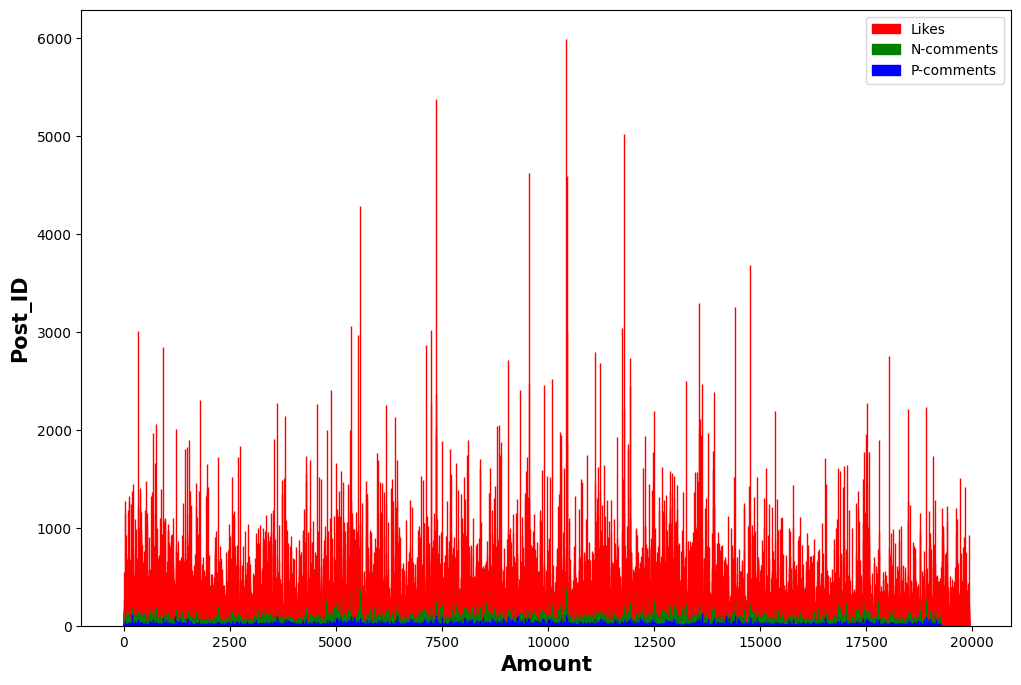

In [235]:
import matplotlib.pyplot as plt 
# Как строить график подсмотрел тут https://www.geeksforgeeks.org/bar-plot-in-matplotlib/
Width = 0.1
fig = plt.subplots(figsize =(12, 8)) 

br1 = np.arange(len(id_dict)) 
br2 = [x + Width for x in br1] 
br3 = [x + Width for x in br2]

plt.bar(br1, [item[0] for item in id_dict.values()], color ='r', width = Width, 
        edgecolor ='r', label ='Likes') 
plt.bar(br2, [item[1] for item in id_dict.values()], color ='g', width = Width, 
        edgecolor ='g', label ='N-comments') 
plt.bar(br3, [item[2] for item in id_dict.values()], color ='b', width = Width, 
        edgecolor ='b', label ='P-comments') 

plt.xlabel('Amount', fontweight ='bold', fontsize = 15) 
plt.ylabel('Post_ID', fontweight ='bold', fontsize = 15) 

plt.legend()
plt.show()


Ответ - правда, на графике можно заменить параллельные скачки зеленых и красных полосок, которые обозначают лайки и негативные комментарии

__[0.6 балла] Задание 13:__  Давайте построим по сентимент-окрасу комментариев топ позитивных новостей.

- Если под новостью оставлено 100 комментариев, из которых 80 позитивные, мы можем быть уверены в том, что новость была хорошо воспринята людьми.
- Если под новостью всего один комментарий и он оказался позитивным, то у нас 100% позитивных комментариев, но это вовсе не означает, что новость была воспринята хорошо.

Получается, что сортировать по доле позитивных комментариев нельзя. Давайте поступим умнее. Доля позитивных комментариев под постом -- это случайная величина. Её довольно часто моделируют с помощью бета-распределения. Если это случайная величина, мы можем построить для неё предиктивный интервал. Пусть $u$ - число позитивных комментариев, а $d$ - нейтральных и негативных.  Пусть

$$
a = 1 + u \qquad b = 1 + d.
$$

Тогда нижняя граница $95\%$ предиктивного интервала для доли будет вычисляться по такой формуле:

$$
\frac{a}{a + b} - 1.65 \cdot \sqrt{\frac{a \cdot b}{(a + b)^2 \cdot (a + b + 1)}}
$$

Если под новостью был всего один комментарий, у такой случайной величины будет высокая дисперсия. Это означаeт, что штука, которую мы вычитаем из доли, окажется высокой. Левая граница интервала окажется маленькой и мы не поднимем комментарий в нашем топе наверх. Фактически мы делаем сортировку по квантилю уровня $0.05$ вместо среднего.

От вас требуется вбить эту формулу, сделать сортировку и вывести на экран топ позитивных новостей. Подробнее про то, откуда берётся эта формула можно почитать [в этой книге.](https://disk.yandex.ru/i/Ctd08bTwC9eI3g) Ищите 4 главу, страницу 140.

In [237]:
def formula(a, b):
    first_element = a / (a+b)
    second_element = 1.65 * np.sqrt((a*b)/((a+b)**2)*(a+b+1))
    return first_element - second_element


In [245]:
df_scomment.head()

,Unnamed: 0,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score,Quantity of comments,Quantity of positive comments,Quantity of negative comments,Like_amount
0,0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0,neutral,0.912246,47,3.0,10.0,44.0
1,1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0,neutral,0.879370,47,3.0,10.0,44.0
2,2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого всей фабрике.",4.0,positive,0.676261,47,3.0,10.0,44.0
3,3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0,neutral,0.925939,47,3.0,10.0,44.0
4,4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0,neutral,0.866223,47,3.0,10.0,44.0


In [250]:
df_scomment["Positivity"] = df_scomment.apply(
    lambda x: formula((x['Quantity of positive comments'] + 1), (x['Quantity of negative comments'] + 1)),
    axis=1)
positive_news = list(df_scomment.sort_values(ascending = False, by = "Positivity").post_id.unique())


In [252]:
df_vk[df_vk.id.isin(positive_news[:10])]

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean
1502,23626018,/20190102/1548983193.html,2019-01-02 05:46:17,российские ученые создали фильтры из водорослей для очистки воды от нефти,305,40,#UNKN,российские ученые создали фильтры из водорослей для очистки воды от нефти,#UNKN
2548,23397771,/20181212/1547890259.html,2018-12-12 16:38:50,"поиски ""титаника"" были прикрытием для операции вмс сша, пишут сми",122,30,#UNKN,поиски титаника были прикрытием для операции вмс сша пишут сми,#UNKN
5123,22726605,/culture/20181017/1530852409.html?referrer_block=index_daynews3_4,2018-10-17 11:19:26,"умер актер из сериала ""склифосовский""",112,37,#UNKN,умер актер из сериала склифосовский,#UNKN
7407,22112596,/world/20180828/1527330927.html,2018-08-28 02:13:16,"экс-сотрудник цру рассказал о блефе американских спецслужб о ""информаторах в россии""",141,25,#UNKN,экссотрудник цру рассказал о блефе американских спецслужб о информаторах в россии,#UNKN
8951,21704342,/society/20180721/1525072828.html,2018-07-22 01:32:14,в алтайском крае появился памятник варенику,295,70,#UNKN,в алтайском крае появился памятник варенику,#UNKN
11837,20832248,/science/20180509/1520175491.html,2018-05-09 23:37:36,геймеры и ученые провели самую массовую проверку квантовой физики,202,32,#UNKN,геймеры и ученые провели самую массовую проверку квантовой физики,#UNKN
13779,20115293,/world/20180322/1516982510.html,2018-03-22 03:52:44,в кремле назвали последствия выхода сша из соглашения по про,182,36,решение американской стороны покинуть договор поставило под угрозу международную стабильность и безопасность.,в кремле назвали последствия выхода сша из соглашения по про,решение американской стороны покинуть договор поставило под угрозу международную стабильность и безопасность
14182,19966673,/world/20180312/1516129353.html,2018-03-12 00:21:45,"замглавы минобороны россии: нато создает в европе зону ""военного шенгена""",90,27,"идею создания ""военного шенгена"" первоначально выдвинул экс-командующий сухопутными войсками сша в европе генерал-лейтенант бен ходжес, по словам которого, союзнические войска и военная техника должны быть способны перемещаться по территории континента ""столь же быстро, как и мигранты"".",замглавы минобороны россии нато создает в европе зону военного шенгена,идею создания военного шенгена первоначально выдвинул экскомандующий сухопутными войсками сша в европе генераллейтенант бен ходжес по словам которого союзнические войска и военная техника должны быть способны перемещаться по территории континента столь же быстро как и мигранты
14722,19767583,/syria/20180226/1515258855.html,2018-02-26 01:08:41,в сирии рассказали о гибели мирных жителей от авиаударов коалиции сша,117,26,#UNKN,в сирии рассказали о гибели мирных жителей от авиаударов коалиции сша,#UNKN
15823,19400581,/society/20180127/1513455534.html?referrer_block=index_daynews2_2,2018-01-27 15:00:52,умер секретарь союза журналистов россии борис резник,133,23,#UNKN,умер секретарь союза журналистов россии борис резник,#UNKN


Построили? Срочно пришлите свою любимую позитивную  новость в общий чат!!!

Топ негативных новостей строить не будем. Вокруг итак слишком много негатива 😻😻😻

__[0.6 балла] Задание 14:__ Какие категории новостей оказались самыми позитивными? Придумайте способ найти такие категории и опишите его тут.

__Ответ:__

In [ ]:
# your code here
# ٩(⁎❛ᴗ❛⁎)۶

__[0.2 балла] Бонусное задание 3:__ Проанализируйте, как температура комментария (вероятность того, что он негативный) зависит от длины трэда (число комментариев под новостью)? Значима ли эта взаимосвязь? Если вам для проверки этого хочется построить линейную регрессию, не сдерживайтесь.

In [ ]:
# your code here
# ヾ(๑╹◡╹)ﾉ